The aim in this file is to show how to use `keras embedding layers` together with `LSTM`, `GRU`, `bidirectional GRU` and affects of adding  `droupout` & `recurrent_dropout` to advoid overfiting problem!

In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%time df = pd.read_csv(r"D:\Nhan\Data\XTX_data.csv")

print(df.shape)
df.head(8)

Wall time: 14.9 s
(2999999, 61)


,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,...,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,y
0,1619.5,1620.0,1621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
1,1619.5,1620.0,1621.0,1621.5,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
2,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
3,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
4,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
5,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
6,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
7,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,1623.5,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5


In [2]:
df = df = df.fillna(0)
df.head()

,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,...,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,y
0,1619.5,1620.0,1621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
1,1619.5,1620.0,1621.0,1621.5,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
2,1619.5,1620.0,1621.0,1621.5,1622.0,0.0,0.0,0.0,0.0,0.0,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
3,1619.5,1620.0,1621.0,1621.5,1622.0,0.0,0.0,0.0,0.0,0.0,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
4,1619.5,1620.0,1621.0,1621.5,1622.0,0.0,0.0,0.0,0.0,0.0,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5


#### Generating function on lookback and delay; yielding timeseries samples and their targets 

- `min_index` and `max_index`—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- `shuffle` — Whether to shuffle the samples or draw them in chronological order

In [3]:
def generator(data, 
              lookback, ## Observations will go back some days, e.g 5 days = 720 lookback.
              delay,   ## Targets will be 24 hours in the future
              min_index, 
              max_index, 
              shuffle = False, 
              batch_size = 128, ## The number of samples per batch; default = 128
              step = 6  ## Observations will be sampled at one data point per hour (10 mins/ timestep).
             ):
    
    X = data.iloc[:, :-1]
    y = data.y.cumsum()
    
    ## normalize data
    X = X.to_numpy()
    mean = X.mean(axis=0)
    X -= mean
    std = X.std(axis=0)
    X /= std
    
    ## normalize target
    y -= y.mean()
    y /= y.std()
    
    # generate sample & target
    if max_index is None:
        max_index = len(X) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros(( len(rows), lookback // step, X.shape[-1] ))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = X[indices]
            targets[j] = y[rows[j] + delay]
        return samples, targets

In [4]:
train_rate = 0.6
nb_train = int(len(df)*train_rate)
nb_vld = int(len(df) * 0.2)

lookback, step, delay, batch_size = 100, 2, 1, 128

train_gen = generator(df,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index = nb_train,
                        step=step,
                        batch_size=batch_size)
## Validation generator
val_gen = generator(df,
                        lookback=lookback,
                        delay = delay,
                        min_index = nb_train + 1,
                        max_index = nb_train + nb_vld,
                        step=step,
                        batch_size=batch_size)
test_gen = generator(df,
                        lookback=lookback,
                        delay=delay,
                        min_index = nb_train + nb_vld + 1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size)

X_train, y_train = train_gen
X_test, y_test = test_gen
X_val, y_val = val_gen

X_train.shape, X_test.shape, X_val.shape, y_train.shape

((128, 50, 60), (128, 50, 60), (128, 50, 60), (128,))

## Without using LSTM

The following listing shows a `fully connected model` that starts by `flattening` the data and then runs it through `4 Dense layers`. Note the `lack of` `activation function` on the `last Dense layer`, which is typical for a `regression problem`. 

We will use `MAE (mean absolute error)` as the loss. Because we want to evaluate on the `exact same data` and with the `exact same metric` we have done with the `common-sense approach`, the results will be `directly comparable`.

In [5]:
from keras.models import Sequential
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Flatten, Dense

model_0 = Sequential()
model_0.add(layers.Flatten(input_shape=(lookback // step, X_train.shape[-1])))
model_0.add(layers.Dense(64))
model_0.add(layers.Dense(32))
model_0.add(layers.Dense(16, activation='relu'))
model_0.add(layers.Dense(1))
model_0.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192064    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 194,689
Trainable params: 194,689
Non-trainable params: 0
_________________________________________________________________


In [6]:
from keras.optimizers import RMSprop

model_0.compile(optimizer=RMSprop(), loss='mae')
history = model_0.fit(X_train, y_train,
                        steps_per_epoch = 150,
                        epochs = 15,
                        validation_data = val_gen,
                        validation_steps = 100)

Train on 128 samples, validate on 128 samples
Epoch 1/15
150/150 [==============================] - 1s 6ms/step - loss: 0.5047 - val_loss: 0.0257
Epoch 2/15
150/150 [==============================] - 1s 4ms/step - loss: 0.1434 - val_loss: 0.0364
Epoch 3/15
150/150 [==============================] - 1s 4ms/step - loss: 0.0994 - val_loss: 0.0293
Epoch 4/15
150/150 [==============================] - 1s 4ms/step - loss: 0.1019 - val_loss: 0.0313
Epoch 5/15
150/150 [==============================] - 1s 4ms/step - loss: 0.1005 - val_loss: 0.0338
Epoch 6/15
150/150 [==============================] - 1s 8ms/step - loss: 0.0845 - val_loss: 0.0356
Epoch 7/15
150/150 [==============================] - 1s 5ms/step - loss: 0.0795 - val_loss: 0.0396
Epoch 8/15
150/150 [==============================] - 1s 4ms/step - loss: 0.1202 - val_loss: 0.0392
Epoch 9/15
150/150 [==============================] - 1s 4ms/step - loss: 0.0781 - val_loss: 0.0399
Epoch 10/15
150/150 [==============================] -

#### Display the loss curves for validation and training

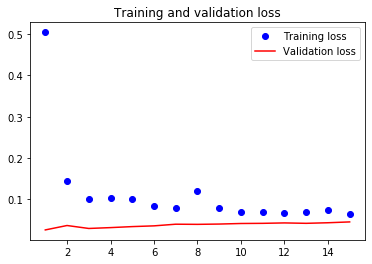

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluate loss and `mae`

In [8]:
from sklearn.metrics import mean_absolute_error as MAE
from statsmodels.tsa.stattools import acf

pred = model_0.predict(X_test)

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 8.283381787840916,
loss = 1 - acf1 = 0.05081297410920238 


## Using LSTM model



In [9]:
from keras.layers import LSTM

m1 = Sequential()
m1.add(Embedding(64, X_train.shape[-1]))
m1.add(LSTM(64, dropout = 0.1, recurrent_dropout = 0.1))
m1.add(Dense(32, activation = 'relu'))
m1.add(Dense(1))
m1.compile(optimizer = 'rmsprop', 
              loss = 'mae')
m1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 60)          3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                32000     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 37,953
Trainable params: 37,953
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = m1.fit(X_train.reshape(128, -1), y_train,
                    shuffle = False,
                    steps_per_epoch = 25,
                    epochs = 10,
                    validation_data = (X_val.reshape(128, -1), y_val),
                    validation_steps = 15)

C:\Users\Admin\.conda\envs\projecy\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 128 samples, validate on 128 samples
Epoch 1/10
25/25 [==============================] - 85s 3s/step - loss: 0.3922 - val_loss: 0.0762
Epoch 2/10
25/25 [==============================] - 80s 3s/step - loss: 0.1364 - val_loss: 0.0947
Epoch 3/10
25/25 [==============================] - 79s 3s/step - loss: 0.1047 - val_loss: 0.0816
Epoch 4/10
25/25 [==============================] - 68s 3s/step - loss: 0.0954 - val_loss: 0.0925
Epoch 5/10
25/25 [==============================] - 68s 3s/step - loss: 0.0851 - val_loss: 0.0825
Epoch 6/10
25/25 [==============================] - 70s 3s/step - loss: 0.0781 - val_loss: 0.0924
Epoch 7/10
25/25 [==============================] - 71s 3s/step - loss: 0.0733 - val_loss: 0.0821
Epoch 8/10
25/25 [==============================] - 70s 3s/step - loss: 0.0693 - val_loss: 0.0908
Epoch 9/10
25/25 [==============================] - 70s 3s/step - loss: 0.0657 - val_loss: 0.0825
Epoch 10/10
25/25 [==============================] - 70s 3s/step - loss:

With only `25 step/epochs` at training and only `15 steps at validation`, but the `LSTM` takes about `3-5 seconds / step`, so it it might be not a `good method` to train a model!

In the next section, we will try `GRU 's model`

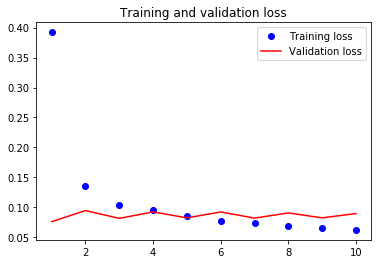

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From `epoch 4`, the `validation loss` is higher than the `training loss` which implies that this model still `significantly overfitting`!

In [12]:
pred = m1.predict(X_test.reshape(128, -1))

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 1.846721226568627,
loss = 1 - acf1 = 0.09808004696779371 


##  Training and evaluating a GRU-based model

**`Gated recurrent unit (GRU)`** layers work using the same principle as `LSTM`, but they’re somewhat `streamlined and thus
cheaper to run` (***although they may not have as much representational power as LSTM)***. This trade-off between computational expensiveness and representational power is seen everywhere in `machine learning`.

In [13]:
# How many steps to draw from val_gen in order to see the entire validation se
val_steps = (nb_vld - 1 - lookback) ## i.e.: (nb_vld + nb_train) - (nb_train + 1) - lookback

# How many steps to draw from test_gen in order to see the entire test set 
test_steps = (len(df) - (nb_train + nb_vld + 1) - lookback)
val_steps, test_steps

(599898, 599900)

In [14]:
model_2 = Sequential()
model_2.add(layers.GRU(32, input_shape = (None, X_train.shape[-1])))
model_2.add(layers.Dense(1))
model_2.compile(optimizer = RMSprop(), 
              loss = 'mae')
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                8928      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model_2.fit(X_train, y_train,
                        shuffle = False,
                        steps_per_epoch = 500,
                        epochs = 20,
                        validation_data = (X_val, y_val),
                        validation_steps = val_steps)

Train on 128 samples, validate on 128 samples
Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0715 - val_loss: 0.0020
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0320 - val_loss: 0.0039
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0194 - val_loss: 0.0057
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0159 - val_loss: 0.0077
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0144 - val_loss: 0.0114
Epoch 6/20
500/500 [==============================] - 21s 41ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0126 - val_loss: 0.0140
Epoch 8/20
500/500 [==============================] - 19s 38ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 9/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0122 - val_loss: 0.0144
Epoch 10/20
500/500 [===============

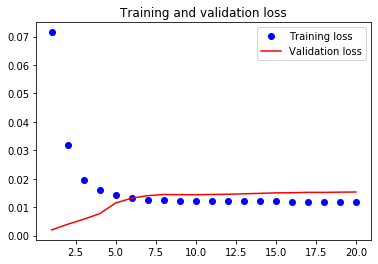

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
import time 
start_time = time.time()

In [18]:
model_2.save('XTX_group.h5')

#### predict

In [19]:
from keras.models import load_model

model = load_model('XTX_group.h5')

pred = model.predict(X_test)

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 0.4765582911341311,
loss = 1 - acf1 = 0.04410216110143239 


### Drop-out combine with GRU

**Using `recurrent dropout` to fight `overfitting`**. 

It’s `evident` from the `training` and `validation curves` that the model is `overfitting`: the training and validation losses start to diverge considerably after a few epochs. We’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 

But how to correctly apply `dropout` in `recurrent networks` isn’t a trivial question. It has long been known that applying dropout before a `recurrent layer` hinders learning rather than helping with `regularization`. 

In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: `the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep`.

What’s more, in order to regularize the representations formed by the recurrent gates of layers such as `GRU` and `LSTM`, a temporally `constant dropout mask` should be applied to the inner `recurrent activations` of the layer (a `recurrent dropout mask`). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Every recurrent layer in Keras has `two dropout-related arguments`: 
> `dropout`, a float specifying the dropout rate for input units of the layer, and
>
> `recurrent_dropout`, specifying the dropout rate of the recurrent units. 

Let’s add `dropout` and `recurrent dropout` to the `GRU layer` and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, you’ll train the network for twice as many epochs.

In [20]:
model_3 = Sequential()
model_3.add(layers.GRU(32,
                        dropout=0.1,
                        recurrent_dropout=0.1,
                        return_sequences=True,
                        input_shape=(None, X_train.shape[-1])))
model_3.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.1))
model_3.add(layers.Dense(1))
model_3.compile(optimizer=RMSprop(), loss='mae')
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 32)          8928      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 27,617
Trainable params: 27,617
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model_3.fit(X_train, y_train,
                        steps_per_epoch = 500,
                        epochs = 40,
                        validation_data = (X_val, y_val),
                        validation_steps = val_steps)

Train on 128 samples, validate on 128 samples
Epoch 1/40
500/500 [==============================] - 52s 103ms/step - loss: 0.0760 - val_loss: 0.0034
Epoch 2/40
500/500 [==============================] - 46s 91ms/step - loss: 0.0401 - val_loss: 0.0040
Epoch 3/40
500/500 [==============================] - 44s 89ms/step - loss: 0.0326 - val_loss: 0.0045
Epoch 4/40
500/500 [==============================] - 45s 91ms/step - loss: 0.0284 - val_loss: 0.0048
Epoch 5/40
500/500 [==============================] - 46s 91ms/step - loss: 0.0259 - val_loss: 0.0050
Epoch 6/40
500/500 [==============================] - 44s 88ms/step - loss: 0.0242 - val_loss: 0.0050
Epoch 7/40
500/500 [==============================] - 44s 88ms/step - loss: 0.0227 - val_loss: 0.0050
Epoch 8/40
500/500 [==============================] - 45s 89ms/step - loss: 0.0217 - val_loss: 0.0051
Epoch 9/40
500/500 [==============================] - 45s 89ms/step - loss: 0.0207 - val_loss: 0.0052
Epoch 10/40
500/500 [==============

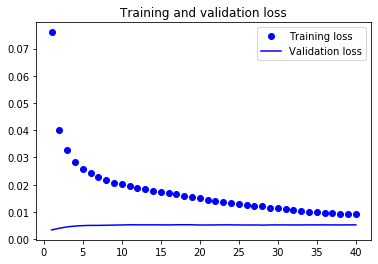

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
pred = model_3.predict(X_test)

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 1.8190339489237544,
loss = 1 - acf1 = 0.05724752285093948 


## Training and evaluating a `bidirectional LSTM`

In [28]:
model_4 = Sequential()
model_4.add(layers.Embedding(32, X_train.shape[-1]))
model_4.add(layers.Bidirectional(layers.LSTM(32)))
model_4.add(layers.Dense(1, activation='relu'))

model_4.compile(optimizer='rmsprop', loss='mae')
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 60)          1920      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                23808     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 25,793
Trainable params: 25,793
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model_4.fit(X_train.reshape(128, -1), y_train,
                        epochs = 10,
                        steps_per_epoch = 100,
                        validation_split = 0.2, 
                      validation_steps = val_steps)

C:\Users\Admin\.conda\envs\projecy\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102 samples, validate on 26 samples
Epoch 1/10
100/100 [==============================] - 567s 6s/step - loss: 1.2504 - val_loss: 0.0198
Epoch 2/10
100/100 [==============================] - 549s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 3/10
100/100 [==============================] - 543s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 4/10
100/100 [==============================] - 540s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 5/10
100/100 [==============================] - 541s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 6/10
100/100 [==============================] - 536s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 7/10
100/100 [==============================] - 543s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 8/10
100/100 [==============================] - 542s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 9/10
100/100 [==============================] - 537s 5s/step - loss: 1.2503 - val_loss: 0.0198
Epoch 10/10
100/100 [=========================

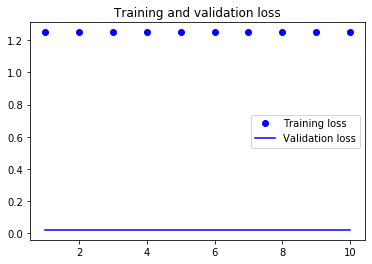

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
pred = model_4.predict(X_test.reshape(128, -1))

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 0.7025788819746255,
loss = 1 - acf1 = 0.019612712333100468 


## Training a `bidirectional GRU`

In [33]:
model_5 = Sequential()
model_5.add(layers.Bidirectional(
    layers.GRU(32), 
    input_shape=(None, X_train.shape[-1])))
model_5.add(layers.Dense(1))
model_5.compile(optimizer=RMSprop(), loss='mae')
model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 64)                17856     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model_5.fit(X_train, y_train,
                        steps_per_epoch = 200,
                        epochs = 40,
                        validation_data = (X_val, y_val),
                        validation_steps = val_steps)

Train on 128 samples, validate on 128 samples
Epoch 1/40
200/200 [==============================] - 18s 88ms/step - loss: 0.1566 - val_loss: 0.0010
Epoch 2/40
200/200 [==============================] - 17s 86ms/step - loss: 0.0952 - val_loss: 9.2603e-04
Epoch 3/40
200/200 [==============================] - 17s 86ms/step - loss: 0.0710 - val_loss: 7.1533e-04
Epoch 4/40
200/200 [==============================] - 18s 88ms/step - loss: 0.0555 - val_loss: 6.5993e-04
Epoch 5/40
200/200 [==============================] - 18s 88ms/step - loss: 0.0462 - val_loss: 6.7793e-04
Epoch 6/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0399 - val_loss: 7.4047e-04
Epoch 7/40
200/200 [==============================] - 19s 96ms/step - loss: 0.0353 - val_loss: 8.1583e-04
Epoch 8/40
200/200 [==============================] - 18s 91ms/step - loss: 0.0314 - val_loss: 7.9913e-04
Epoch 9/40
200/200 [==============================] - 18s 91ms/step - loss: 0.0289 - val_loss: 8.0341e-04
Epoc

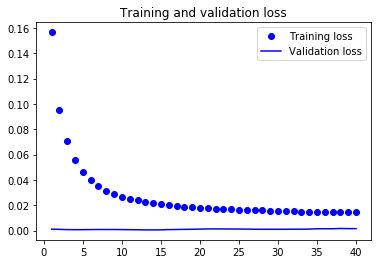

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
pred = model_5.predict(X_test)

mae = MAE(pred, y_test)
loss = 1 - acf(pred.ravel() - y_test.ravel(), fft = False)[1]

print('MAE = %s,\nloss = 1 - acf1 = %s '%(mae, loss))

MAE = 0.26001188975263845,
loss = 1 - acf1 = 0.04260906165244083 
